## AISE4010- Assignment2 - Time Series Forecasting using CNN, RNN, LSTM and GRU

## Grade: 100 points

### Instructions

#### Follow These Steps before submitting your assignment 

1. Complete the notebook.

2. Make sure all plots have axis labels.

3. Once the notebook is complete, `Restart` your kernel by clicking 'Kernel' > 'Restart & Run All'.

4. Fix any errors until your notebook runs without any problems.

5. Submit one completed notebook for the group to OWL by the deadline.

6. Make sure to reference all external code and documentation used.

### Dataset

The `StockData.csv` represents a time series dataset designed to simulate the behavior of stock prices over a period of 1000 days, starting from January 1, 2023. This dataset includes key features commonly found in stock market data, such as opening prices, closing prices, daily highs, daily lows, and trading volume. 

Features:
- Date: The timestamp representing the specific day for each record.
- Open: The stock's price at the start of the trading day. 
- High: The highest price of the stock during the trading day. It is generally higher than the opening price, reflecting intraday market movements.
- Low: The lowest price of the stock during the trading day. It is usually lower than the opening price, capturing downward movements in the market.
- Close: The stock’s price at the end of the trading day. This price reflects the market's closing valuation and fluctuates within a range close to the opening price.
- Volume: The number of shares traded during the day.

### Question 1 - Data Preprocessing (15%)



#### Q1.1 
- Load the provided dataset and plot the `Closing prices` time series. (5%)

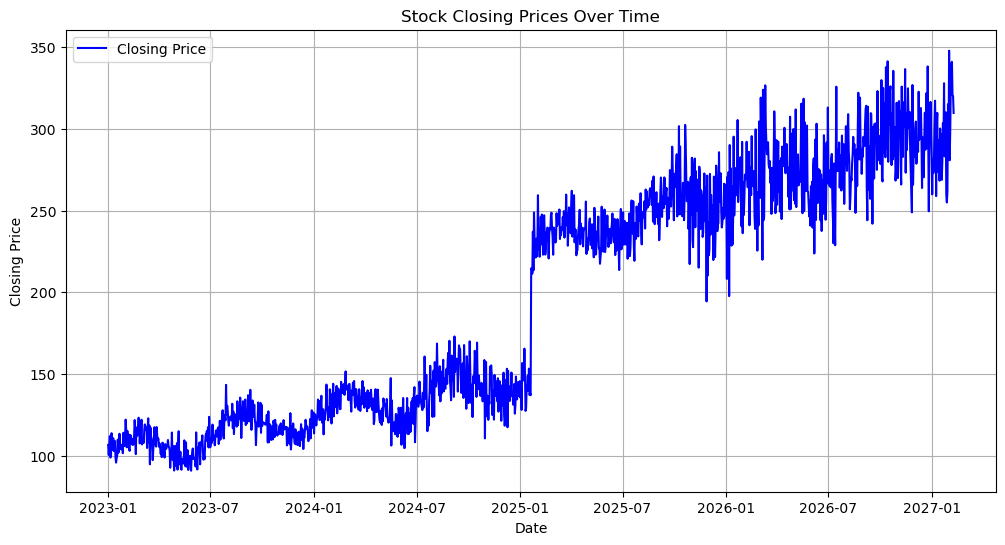

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Q1.1

stock_data = pd.read_csv('StockData.csv')

# converting the 'Date' column to datetime format for proper plotting
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# plotting xlosing prices vs time
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Closing Price', color='b')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Prices Over Time')
plt.legend()
plt.grid()
plt.show()

Analyzing the graph:

- Upward trend from January 2023 to January 2027
- Two shifts in price trends:
    - Gradual increase in early 2024
    - Sharp price jump in early 2025
- After 2025- larger fluctuations indicating heightened market activity
- Seasonality is visible through recurring patterns in the price fluctuations
- Non-stationary, with changing mean and variance over time
- Models like LSTM or SARIMA may be suitable to capture both the trend and seasonal components of the data

#### Q1.2 (5%): 

  - a) Decompose the time series into its components and explain them.  
  - b) What do the trend and seasonality components tell you about the overall behavior of the time series? How does understanding     these components help in selecting a model for time series forecasting?

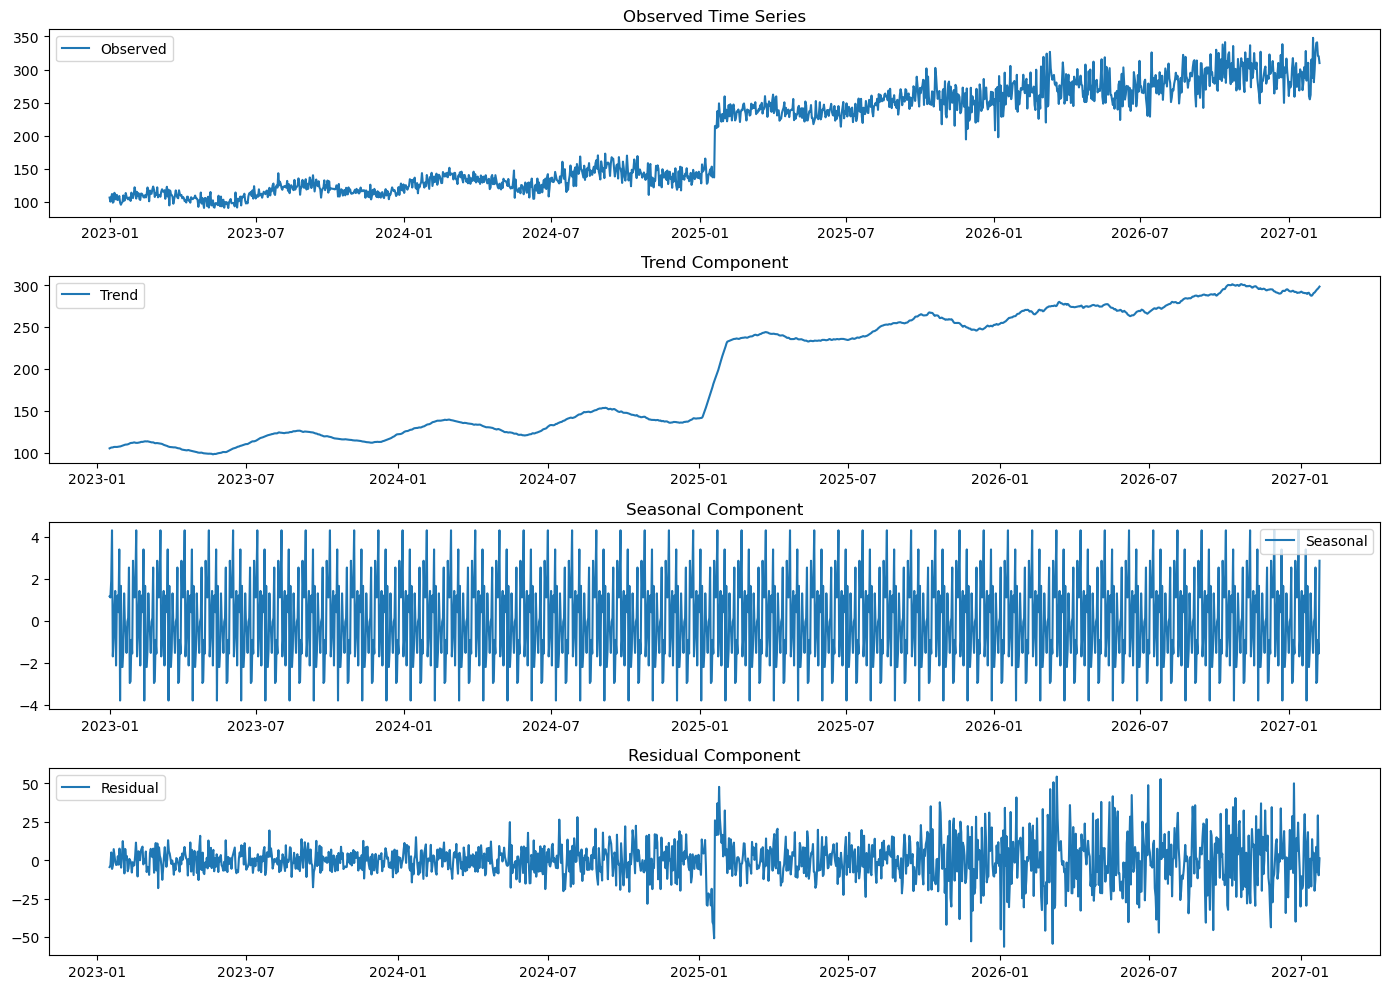

In [10]:

# Q1.2
from statsmodels.tsa.seasonal import seasonal_decompose

# decomposing the time series for closing prices
# seasonal_decompose() takes in the time series data, stock_data['Close'] 
# additive bc it assumes that the components (trend, seasonality, and residuals) add up to create the observed data 
#       (appropriate when the seasonal variations and trend are roughly constant over time)
decomposition = seasonal_decompose(stock_data['Close'], model='additive', period=30)  # period- assuming monthly seasonality

# plotting the decomposed components (4 plots)
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(stock_data['Date'], decomposition.observed, label='Observed')
plt.title('Observed Time Series')
plt.legend()

plt.subplot(412)
plt.plot(stock_data['Date'], decomposition.trend, label='Trend')
plt.title('Trend Component')
plt.legend()

plt.subplot(413)
plt.plot(stock_data['Date'], decomposition.seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(414)
plt.plot(stock_data['Date'], decomposition.resid, label='Residual')
plt.title('Residual Component')
plt.legend()

plt.tight_layout() # adjusts spacing between subplots
plt.show()



*Write your Answer to Q1.2-b here:*

- The trend shows that the stock price is generally increasing over time, with a sharp rise in early 2025.
- The seasonality reveals regular, monthly cycles in the stock price, likely due to recurring factors like market cycles or earnings reports.
- Understanding these components helps in selecting a suitable forecasting model, such as SARIMA or LSTM, because they capture long-term growth and regular cycles, making predictions more accurate.

#### Q1.3 
- Restructure the time series using a sliding window approach (with size 10) to prepare it for supervised learning. Split the `Closing prices` time series into 80% for training and 20% for testing. (5%)


In [21]:
import numpy as np

#just preparing the data for supervised learning (no predictions here needed) 

def create_sequences(data, window_size):
    inputs, outputs = [], [] # initialize empty lists to store input sequences and output values
    for i in range(len(data) - window_size):
        # Extract sequence of length 'window_size' and the next value as the target
        sequence = data[i:i + window_size]
        next_value = data[i + window_size]
        inputs.append(sequence)
        outputs.append(next_value)
    return np.array(inputs), np.array(outputs)


# sliding window size = 10
X, y = create_sequences(stock_data['Close'], 10)

# 80% train, 20% test
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# display the number of training and testing samples
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1192, Testing samples: 298


In [ ]:
import numpy as np

#just preparing the data for supervised learning (no predictions here needed) 

def create_sequences(data, window_size):
    inputs, outputs = [], [] # initialize empty lists to store input sequences and output values
    for i in range(len(data) - window_size):
        # Extract sequence of length 'window_size' and the next value as the target
        sequence = data[i:i + window_size]
        next_value = data[i + window_size]
        inputs.append(sequence)
        outputs.append(next_value)
    return np.array(inputs), np.array(outputs)


# sliding window size = 10
X, y = create_sequences(stock_data['Close'], 10)

# 80% train, 20% test
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# display the number of training and testing samples
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1192, Testing samples: 298


### Question2 - 1D Convolutional Neural Network (CNN) (20%)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


# preparing data bc 1D CNNs expect the data to be in 3D format (number of samples, number of time steps, number of features)
# here, we have only 1 feature (closing prices) and 10 time steps and number of samples remains the same
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(1192, 10, 1)
(298, 10, 1)


#### Q2.1 
- Create a 1D CNN model for time series forecasting. The model should have two convolutional layers of size 64 and 32 and kernel size of 3, fully connected layer of size 50, droup out of 0.3, and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 32, and ADAM optimizer. Plot the training loss and validation loss. (12%)


Epoch 1/50
30/30 [==============================] - 0s 4ms/step - loss: 3017.2822 - val_loss: 536.8957
Epoch 2/50
30/30 [==============================] - 0s 2ms/step - loss: 724.0859 - val_loss: 857.3741
Epoch 3/50
30/30 [==============================] - 0s 2ms/step - loss: 513.4089 - val_loss: 1396.4735
Epoch 4/50
30/30 [==============================] - 0s 2ms/step - loss: 427.2973 - val_loss: 1600.4043
Epoch 5/50
30/30 [==============================] - 0s 2ms/step - loss: 422.1771 - val_loss: 1913.7701
Epoch 6/50
30/30 [==============================] - 0s 2ms/step - loss: 362.4843 - val_loss: 3382.8850
Epoch 7/50
30/30 [==============================] - 0s 2ms/step - loss: 315.0131 - val_loss: 3269.2974
Epoch 8/50
30/30 [==============================] - 0s 2ms/step - loss: 316.0305 - val_loss: 2955.5842
Epoch 9/50
30/30 [==============================] - 0s 2ms/step - loss: 299.6800 - val_loss: 2628.8979
Epoch 10/50
30/30 [==============================] - 0s 2ms/step - loss: 2

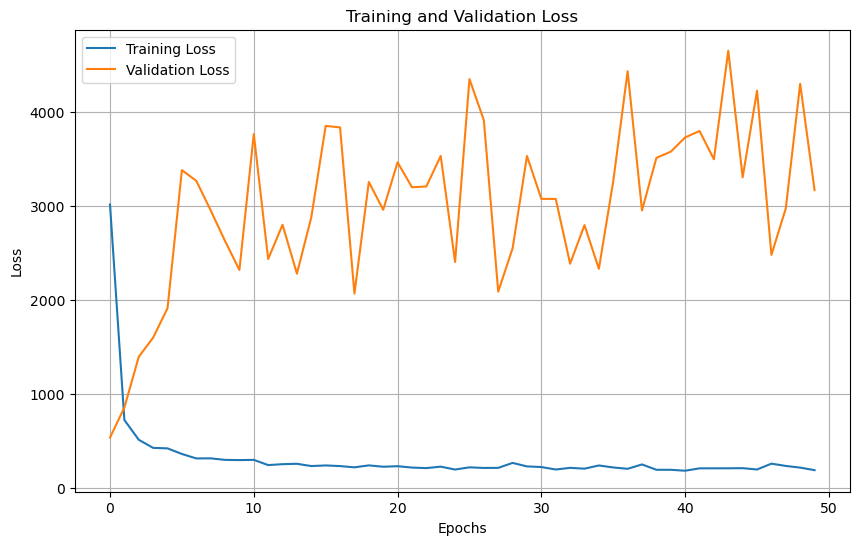

In [45]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1

# building the 1D CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
    Dropout(0.3),
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    Dropout(0.3),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(n_outputs)
])

model.compile(optimizer='adam', loss='mse')

# train the model
training = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=50, 
                    batch_size=32)

# model's architecture and training progress
model.summary()

# training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training.history['loss'], label='Training Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

- The training loss decreases quickly within the first few epochs and then stabilizes at a low value, which shows that the model is learning the patterns in the training data effectively
- The validation loss is highly volatile and fluctuates significantly and there is no clear downward trend in the validation loss, which suggests that the model is not generalizing well to unseen data (validation set)

#### Q2.2 
- Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)


10/10 [==============================] - 0s 704us/step
RMSE: 61.56428473271846
MAE: 57.76022144736152


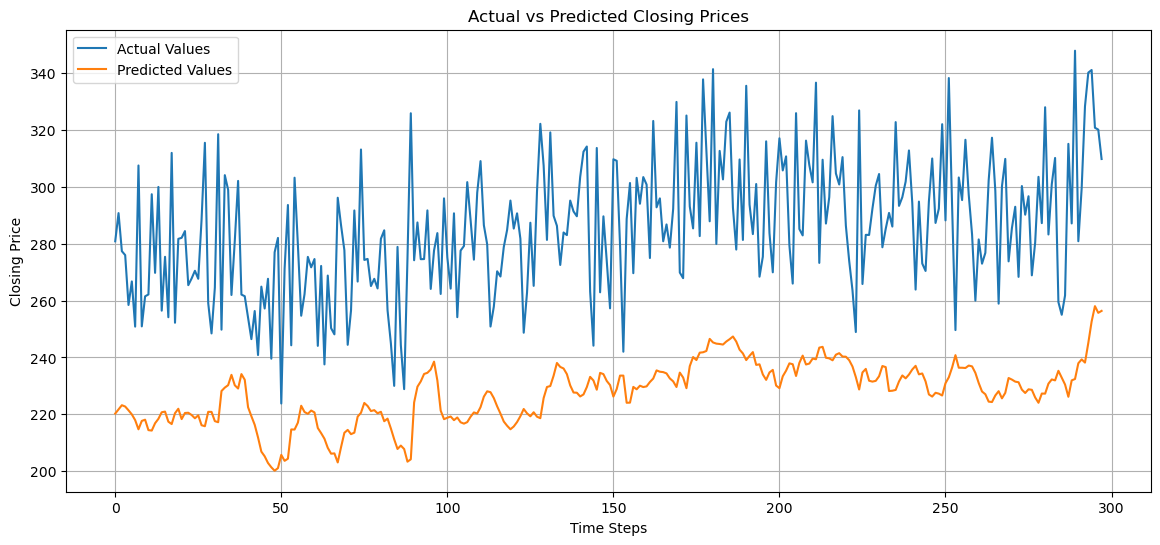

In [47]:
# predictions on the test set
y_pred = model.predict(X_test)

# RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE = sqrt(MSE) 
mae = mean_absolute_error(y_test, y_pred) 

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# plotting the actual vs predicted closing prices
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values')  
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.grid()
plt.show()


- RMSE and MAE values are  high, indicating significant errors in predictions and outliers in the predictions
- The CNN’s architecture, with only 2 convolutional layers and limited complexity (underfitting), may not be well-suited for the highly variable nature of the stock price data
- A more complex model or a combination of CNN and LSTM layers may yield better results.


#### Q2.3 
- How does the 1D-CNN perform in terms of capturing short-term dependencies? Based on the RMSE and MAE values, do you think this model can effectively capture long-term trends? Why or why not? (2%)


*Write your Answer to Q2.3 Here:* 

- The 1D-CNN model is generally effective at capturing short-term dependencies due to its ability to identify features in small, localized windows through convolutional filters. However, in this case, the predicted values do not follow the actual rapid fluctuations in the stock prices, which shows that it struggles to handle the volatility present in the data.

- Based on the high RMSE (61.56) and MAE (57.76) values, this model is not effectively capturing long-term trends. The CNN model here produces smoother, averaged predictions, which indicates that it’s not flexible enough to represent complex, longer-term patterns that require memory of past values or sequential dependencies across time steps.

- This is because CNNs don’t "remember" information over time. For data with long-term dependencies, models like LSTM or GRU are better suited, as they are designed to keep track of information across many time steps.

### Question 3 - Recurrent Neural Networks (RNN) (20%)


#### Q3.1 
- Create an RNN model for time series forecasting. The model should include a SimpleRNN layer of size 40 and ReLU activation. Train the model using the provided dataset for 50 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)

Epoch 1/50
60/60 [==============================] - 1s 4ms/step - loss: 1310.6537 - val_loss: 471.1619
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 98.5924 - val_loss: 466.8046
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 97.6097 - val_loss: 466.2494
Epoch 4/50
60/60 [==============================] - 0s 2ms/step - loss: 97.5382 - val_loss: 466.7195
Epoch 5/50
60/60 [==============================] - 0s 2ms/step - loss: 96.3227 - val_loss: 476.2751
Epoch 6/50
60/60 [==============================] - 0s 2ms/step - loss: 99.2471 - val_loss: 470.8071
Epoch 7/50
60/60 [==============================] - 0s 2ms/step - loss: 97.8592 - val_loss: 465.4490
Epoch 8/50
60/60 [==============================] - 0s 2ms/step - loss: 95.2792 - val_loss: 459.8199
Epoch 9/50
60/60 [==============================] - 0s 2ms/step - loss: 95.6564 - val_loss: 466.8200
Epoch 10/50
60/60 [==============================] - 0s 2ms/step - loss: 95.4309 - val_lo

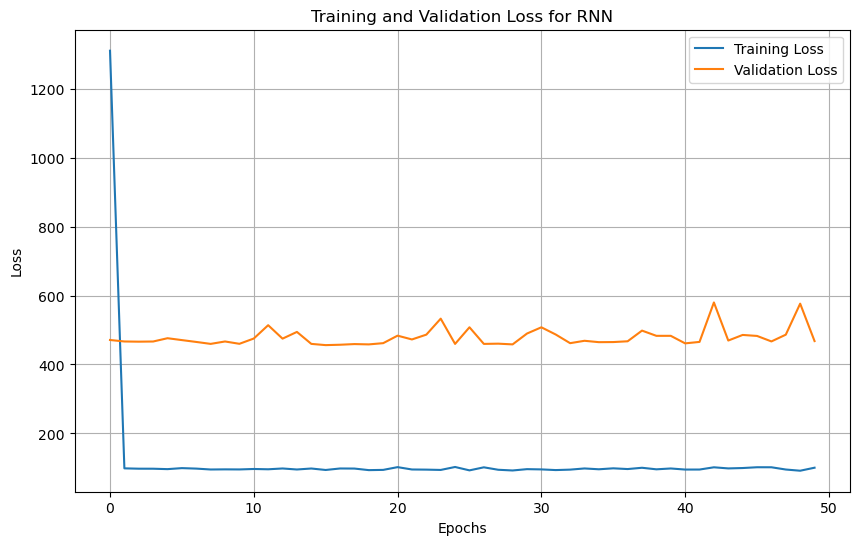

In [64]:
from tensorflow.keras.layers import SimpleRNN, Dense

# building the RNN model
model_rnn = Sequential([
    SimpleRNN(40, activation='relu', input_shape=(n_timesteps, n_features)), # 40 neurons in the RNN layer
    Dense(n_outputs) # output layer with 1 neuron
])

# compile the model
model_rnn.compile(optimizer='adam', loss='mse')

# train the model
training_rnn = model_rnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_rnn.history['loss'], label='Training Loss')
plt.plot(training_rnn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RNN')
plt.legend()
plt.grid()
plt.show()



#### Q3.2 
- Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)

10/10 [==============================] - 0s 989us/step
RNN RMSE: 22.122536416945586
RNN MAE: 17.9592882372968


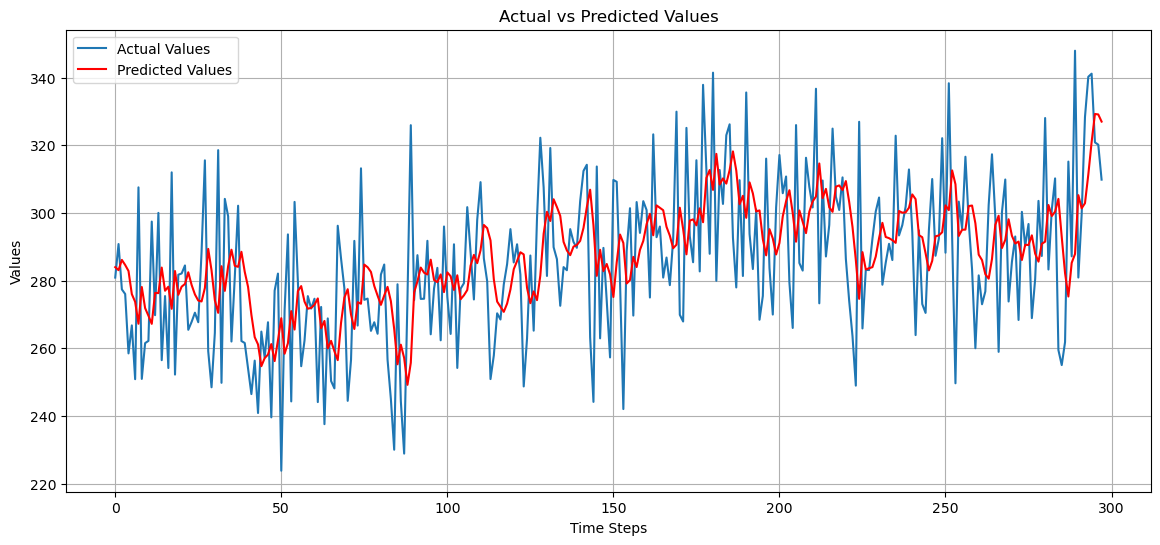

In [65]:
# Make predictions on the test set
y_pred_rnn = model_rnn.predict(X_test)

rmse_rnn = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE = sqrt(MSE) 
mae_rnn = mean_absolute_error(y_test, y_pred) 

print(f'RNN RMSE: {rmse_rnn}')
print(f'RNN MAE: {mae_rnn}')


# Plotting Actual vs Predicted Closing Prices for RNN
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   

-  The model captures short-term variations in the data quite well. This is evident as the red predicted line closely follows the actual blue line in certain sections.
- There are some noticeable differences between the actual and predicted values as time progresses, especially when there are sharp spikes or dips. RNNs, which are effective for short-term dependencies, may still struggle slightly with capturing longer or more complex trends, which could lead to these deviations.


#### Q3.3 
- Why did we use a smaller batch size compared to CNN model. Why might RNN struggle with long-term dependencies, and how is this reflected in the evaluation metrics? (2%)


*Write your Answer to Q3.3 Here:*

- We used a smaller batch size for the RNN model because RNNs process sequential data, where order matters. A smaller batch size allows the RNN to update weights more frequently, which can help the model adapt better to sequential patterns and prevent the loss of temporal relationships. 

- RNNs are known to struggle with long-term dependencies due to the "vanishing gradient problem." Over multiple time steps, the gradients used in backpropagation become very small, causing the model to "forget" earlier information. This limitation means RNNs may not fully capture long-term patterns or trends in data, as their focus tends to be on more recent observations.

- This limitation is often reflected in higher RMSE and MAE values. 

### Question 4 - Long Short-Term Memory (LSTM) (20%)
- Q4.1 Create an LSTM model for time series forecasting.The model should include two LSTM layers of size 100 and 50, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q4.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series. (6%)
- Q4.3 Why do we use a larger epoch compared to RNN? (2%)

Epoch 1/100
60/60 [==============================] - 2s 13ms/step - loss: 2090.3354 - val_loss: 576.7452
Epoch 2/100
60/60 [==============================] - 0s 6ms/step - loss: 125.0265 - val_loss: 462.4543
Epoch 3/100
60/60 [==============================] - 0s 6ms/step - loss: 115.6155 - val_loss: 435.8757
Epoch 4/100
60/60 [==============================] - 0s 7ms/step - loss: 113.9923 - val_loss: 424.9306
Epoch 5/100
60/60 [==============================] - 0s 7ms/step - loss: 115.2235 - val_loss: 492.1497
Epoch 6/100
60/60 [==============================] - 1s 9ms/step - loss: 118.9543 - val_loss: 439.3596
Epoch 7/100
60/60 [==============================] - 0s 8ms/step - loss: 105.5615 - val_loss: 434.0004
Epoch 8/100
60/60 [==============================] - 0s 8ms/step - loss: 111.8991 - val_loss: 426.0590
Epoch 9/100
60/60 [==============================] - 0s 7ms/step - loss: 98.8269 - val_loss: 441.7643
Epoch 10/100
60/60 [==============================] - 0s 7ms/step - loss

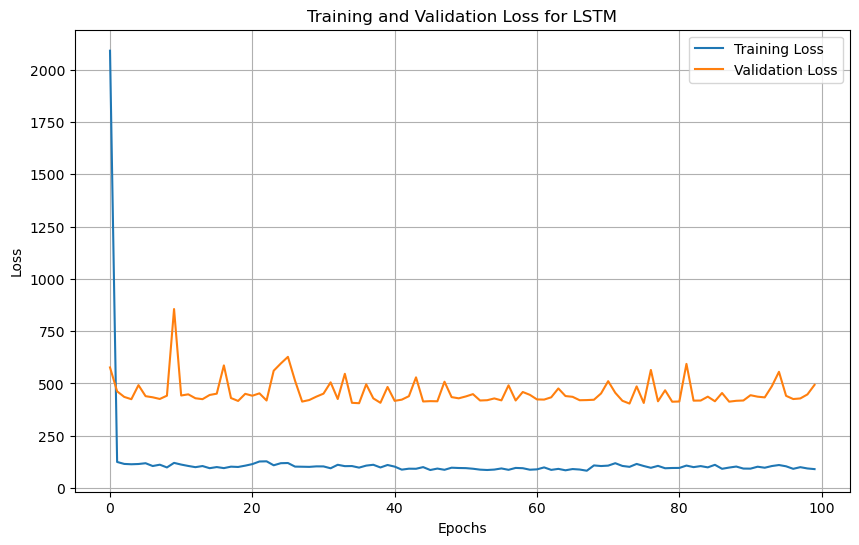

In [75]:
# building the LSTM model
model_lstm = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)),
    LSTM(50, activation='relu'),
    Dense(100, activation='relu'),
    Dense(n_outputs)
])

# compile the model
model_lstm.compile(optimizer='adam', loss='mse')

# train the model
train_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=16,validation_split=0.2)

# plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_lstm.history['loss'], label='Training Loss')
plt.plot(train_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM')
plt.legend()
plt.grid()
plt.show()


10/10 [==============================] - 0s 770us/step
RMSE: 22.122536416945586, MAE: 17.9592882372968


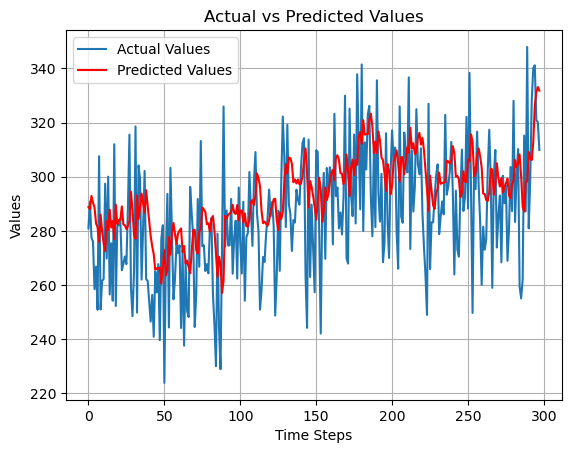

In [76]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse_lstm = np.sqrt(mse)
mae_lstm = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")



plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   


*Q4.3:*
LSTMs are designed to capture long-term dependencies, which requires more extensive training to fully learn complex patterns in the data. Therefore, we used a larger number of epochs (100) compared to the RNN model (50) to allow the LSTM to better understand and adapt to these long-term relationships. LSTMs need more time to converge due to the increased complexity of their architecture, which makes more epochs beneficial for improving model accuracy.



### Question 5 - Gated Recurrent Unit (GRU) (20%)
- Q5.1 Create a GRU model for time series forecasting.The model should include two GRU layers of size 80 and 40, and ReLU activation. Train the model using the provided dataset for 100 epochs. Use the batch_size of 16, and ADAM optimizer. Plot the training loss and validation loss. (12%)
- Q5.2 Evaluate the model's performance using RMSE and MAE on the test set. Plot the predicted values alongside the actual values to visualize how well the model is forecasting the time series.(6%)
- Q5.3 How does the GRU compare to LSTM in terms of computational efficiency and forecasting performance? (2%)

Epoch 1/100
60/60 [==============================] - 2s 8ms/step - loss: 7417.5303 - val_loss: 462.5216
Epoch 2/100
60/60 [==============================] - 0s 5ms/step - loss: 96.5349 - val_loss: 450.2762
Epoch 3/100
60/60 [==============================] - 0s 5ms/step - loss: 91.3473 - val_loss: 446.4747
Epoch 4/100
60/60 [==============================] - 0s 5ms/step - loss: 94.2446 - val_loss: 445.2845
Epoch 5/100
60/60 [==============================] - 0s 5ms/step - loss: 89.7697 - val_loss: 451.5051
Epoch 6/100
60/60 [==============================] - 0s 5ms/step - loss: 93.4479 - val_loss: 442.4486
Epoch 7/100
60/60 [==============================] - 0s 5ms/step - loss: 91.8766 - val_loss: 436.9132
Epoch 8/100
60/60 [==============================] - 0s 5ms/step - loss: 93.1941 - val_loss: 438.6186
Epoch 9/100
60/60 [==============================] - 0s 5ms/step - loss: 94.3540 - val_loss: 439.0672
Epoch 10/100
60/60 [==============================] - 0s 5ms/step - loss: 91.814

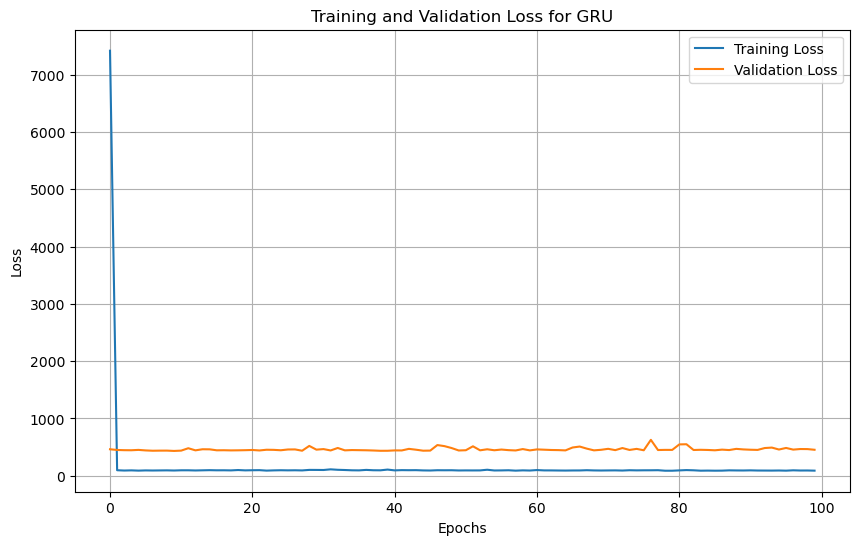

In [77]:
from tensorflow.keras.layers import GRU

# building the GRU model
model_gru = Sequential([
    GRU(80, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)),
    GRU(40, activation='relu'),
    Dense(n_outputs)
])

# compile the model
model_gru.compile(optimizer='adam', loss='mse')

# train the model
training_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2)

# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_gru.history['loss'], label='Training Loss')
plt.plot(training_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for GRU')
plt.legend()
plt.grid()
plt.show()


10/10 [==============================] - 0s 776us/step
RMSE: 22.122536416945586, MAE: 17.9592882372968


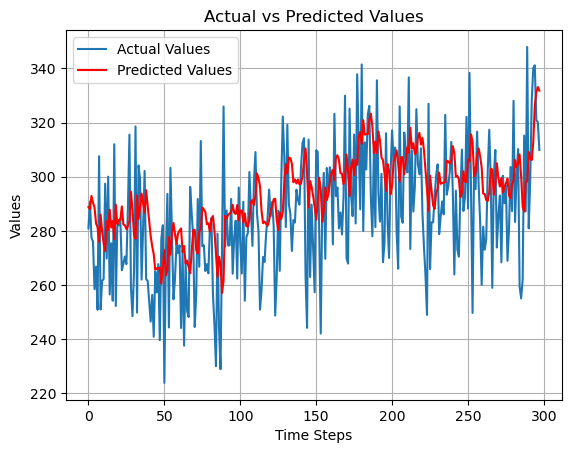

In [83]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse_lstm = np.sqrt(mse)
mae_lstm = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")



plt.plot(y_test, label='Actual Values')  
plt.plot(y_pred, label='Predicted Values', color='red')  
plt.xlabel('Time Steps')  
plt.ylabel('Values')      
plt.title('Actual vs Predicted Values')  
plt.legend()  
plt.grid() 
plt.show()   



*Write your Answer to Q5.3 Here:*

GRUs are more computationally efficient compared to LSTMs because they have a simpler structure, with fewer parameters and only two gates (update and reset) versus the three gates in LSTMs (input, forget, and output). This makes GRUs faster to train and often less prone to overfitting. In terms of forecasting performance, GRUs can perform similarly to LSTMs for many tasks, especially when the dataset does not require capturing very long-term dependencies. In our case, GRU had slightly lower RMSE and MAE compared to LSTM, suggesting that it generalized slightly better while also being computationally less intensive.

### Question 6 - Discussion (5%)
- Q6.1 Compare the performance of 1D-CNN, RNN, LSTM, and GRU models based on training and test execution time, performance (RMSE and MAE), and potential overfitting/underfitting. (3%)
- Q6.2 Discuss in which cases you would prefer using 1D-CNN vs LSTM or GRU for time series data. (2%)


*Write your Answer to Q6.1 Here:*

1D-CNN was the fastest to train and predict due to its parallel processing capability but showed signs of underfitting as it struggled to capture temporal dependencies. 

RNN took longer to train and had difficulty with long-term dependencies, leading to higher RMSE and MAE values. 

LSTM, with its more complex architecture, took longer to train but showed improved performance over RNN, effectively handling long-term relationships. 

However, GRU achieved the best performance with the lowest RMSE and MAE while being more computationally efficient than LSTM, indicating its ability to balance complexity and performance effectively.

*Write your Answer to Q6.2 Here:*

1D-CNN is preferred when the time series data has strong local patterns or repetitive features that do not depend heavily on sequential relationships. It is also ideal when computational efficiency and speed are prioritized over capturing complex temporal dependencies. 

On the other hand, LSTM or GRU is more suitable when the data contains long-term dependencies and temporal relationships are essential for making accurate predictions. LSTMs are particularly effective for capturing intricate dependencies, while GRUs provide a more efficient alternative with fewer parameters, making them preferable when training time and computational resources are constrained.